In [1]:
import torch
import torchvision
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt

In [45]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [19]:
%%capture
!cp -r /content/drive/MyDrive/SSNE/data/train.zip /content/train.zip

In [20]:
%%capture
!cd /content/ && unzip /content/train.zip

In [4]:
train_dir = "data/train"

In [5]:
trainset = ImageFolder(train_dir, transform=torchvision.transforms.ToTensor())

In [10]:
from torch.utils.data import DataLoader

loader = DataLoader(trainset, batch_size=32, shuffle=False)

mean = 0.
std = 0.
nb_samples = 0.

for data, _ in loader:
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    mean += data.mean(2).sum(0)
    std += data.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples

print("Mean:", mean)
print("Std:", std)

Mean: tensor([0.5204, 0.4950, 0.4381])
Std: tensor([0.2113, 0.2103, 0.2100])


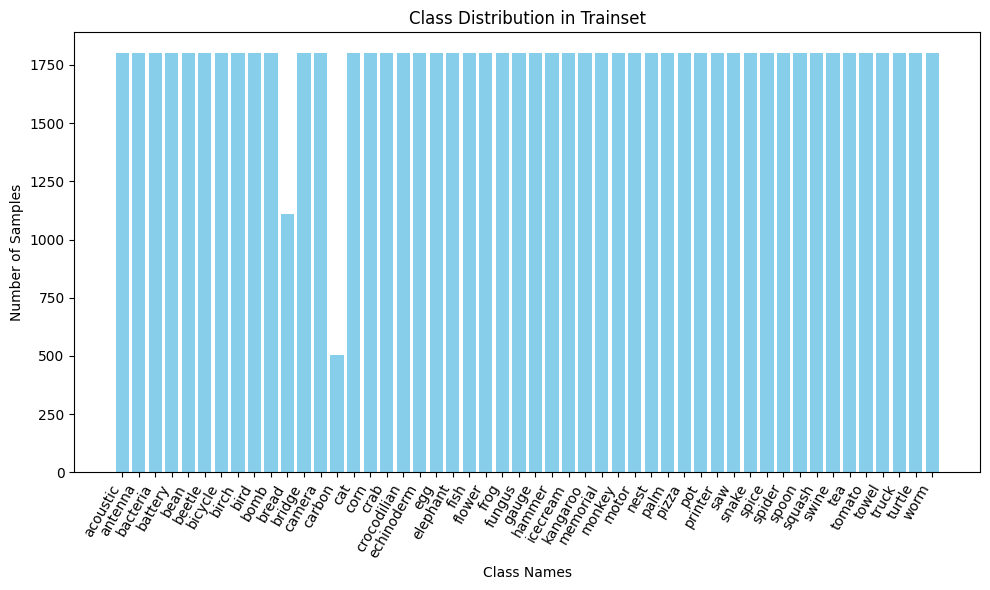

In [7]:
import matplotlib.pyplot as plt
from collections import Counter

class_counts = Counter(trainset.targets)

class_names = trainset.classes
class_distribution = {class_names[idx]: count for idx, count in class_counts.items()}

plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Trainset')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [8]:
from collections import defaultdict
from torch.utils.data import Subset
import random

class_indices = defaultdict(list)
for idx, (_, label) in enumerate(trainset):
    class_indices[label].append(idx)

subset_indices = []
for label, indices in class_indices.items():
    sample_size = max(1, int(0.1 * len(indices)))
    subset_indices.extend(random.sample(indices, sample_size))

balanced_subset = Subset(trainset, subset_indices)

In [25]:
def get_balanced_subset(dataset, data_percent: float):
    """
    Get a balanced subset of the dataset.
    
    Args:
        dataset: The dataset to sample from.
        data_percent (float): Percentage of data to use.
        
    Returns:
        Subset of the dataset with balanced classes.
    """
    assert 0.0 < data_percent <= 1.0, "Percentage must be in range (0.0, 1.0]"

    class_indices = defaultdict(list)
    for idx, label in enumerate(dataset.targets):
        class_indices[label].append(idx)

    total_samples = int(len(dataset) * data_percent)
    num_classes = len(class_indices)
    n_per_class = total_samples // num_classes

    balanced_indices = []

    for label, indices in class_indices.items():
        available = len(indices)
        n_select = min(n_per_class, available)
        if n_select < n_per_class:
            print(f"⚠️ Warning: Class {label} has only {available} samples, selecting {n_select} instead of {n_per_class}.")
        random.shuffle(indices)
        balanced_indices.extend(indices[:n_select])

    print(f"✅ Final subset has {len(balanced_indices)} samples across {len(set(dataset.targets))} classes.")
    return Subset(dataset, balanced_indices)

In [30]:
balanced_subset = get_balanced_subset(trainset, 0.7)

⚠️ Warning: Class 10 has only 1108 samples, selecting 1108 instead of 1232.
⚠️ Warning: Class 13 has only 503 samples, selecting 503 instead of 1232.
✅ Final subset has 60747 samples across 50 classes.


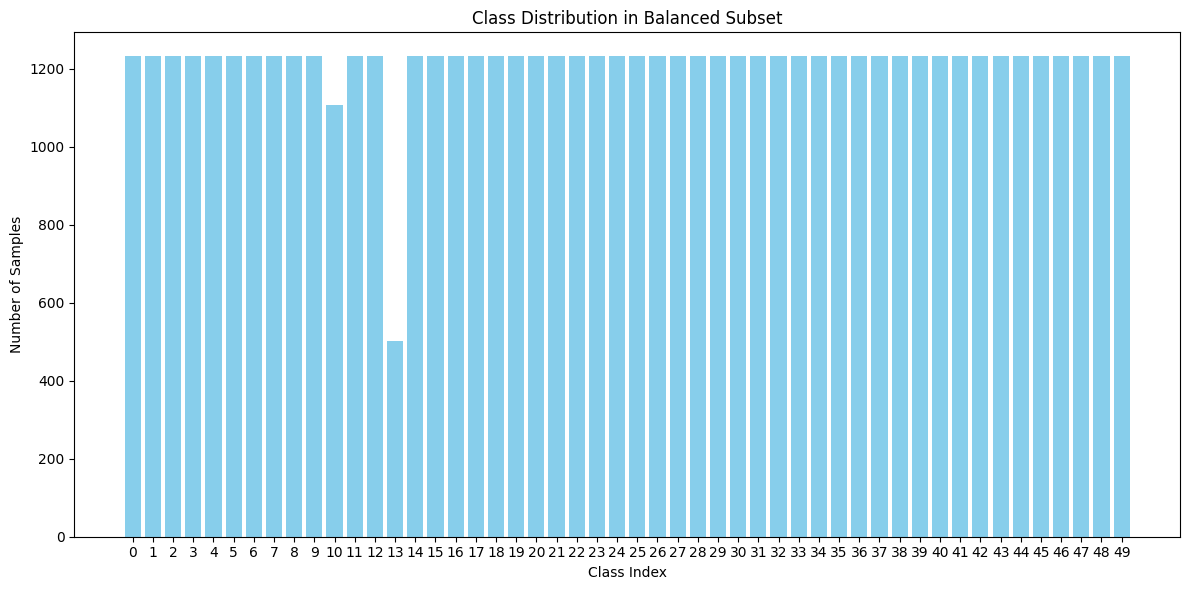

In [31]:
def plot_class_distribution(subset, full_dataset):
    subset_labels = [full_dataset.targets[i] for i in subset.indices]
    class_counts = Counter(subset_labels)

    plt.figure(figsize=(12, 6))
    plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
    plt.xlabel('Class Index')
    plt.ylabel('Number of Samples')
    plt.title('Class Distribution in Balanced Subset')
    plt.xticks(range(len(class_counts.keys())))
    plt.tight_layout()
    plt.show()

plot_class_distribution(balanced_subset, trainset)

In [39]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device
):

  results: dict[str, list[float]] = {
      "Train_Loss": [],
      "Val_Loss": [],
      "Train_Accuracy": [],
      "Val_Accuracy": [],
  }

  for epoch in range(epochs):
    train_loss, train_accuracy = train_step(
        model=model,
        train_dataloader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
    )

    val_loss, val_accuracy = test_step(
        model=model,
        test_dataloader=test_dataloader,
        loss_fn=loss_fn,
        device=device,
    )

    results["Train_Loss"].append(train_loss)
    results["Val_Loss"].append(val_loss)
    results["Train_Accuracy"].append(train_accuracy)
    results["Val_Accuracy"].append(val_accuracy)

  return results

In [40]:
def train_step(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
):
  model.train()
  total_loss = 0
  correct = 0
  total = 0

  for batch, (inputs, targets) in enumerate(train_dataloader):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

  accuracy = correct / total
  total_loss /= len(train_dataloader)

  return total_loss, accuracy


In [41]:
def test_step(
    model: torch.nn.Module,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0

  with torch.inference_mode():
    for batch, (inputs, targets) in enumerate(test_dataloader):
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      total_loss += loss.item()

      _, predicted = torch.max(outputs, 1)
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

  accuracy = correct / total
  total_loss /= len(test_dataloader)

  return total_loss, accuracy

In [42]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

val_split = 0.2
train_size = int((1 - val_split) * len(balanced_subset))
val_size = len(balanced_subset) - train_size

train_subset, val_subset = random_split(balanced_subset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

print(f"Liczba próbek w zbiorze treningowym: {len(train_subset)}")
print(f"Liczba próbek w zbiorze walidacyjnym: {len(val_subset)}")

Liczba próbek w zbiorze treningowym: 7040
Liczba próbek w zbiorze walidacyjnym: 1760


In [43]:
from torchvision.models import resnet18
import torch.optim as optim
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(weights='DEFAULT')
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(model.fc.in_features, len(trainset.classes)).requires_grad_(True)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

In [44]:
train(model, train_loader, val_loader, optimizer, criterion, epochs, device)

{'Train_Loss': [2.993604263934222,
  2.170434200221842,
  1.962860802086917,
  1.829234584353187,
  1.7241465270519256],
 'Val_Loss': [2.3880912694064054,
  2.216779355569319,
  2.1774676431309095,
  2.165345376188105,
  2.208429217338562],
 'Train_Accuracy': [0.2528409090909091,
  0.4323863636363636,
  0.47357954545454545,
  0.5029829545454545,
  0.5269886363636364],
 'Val_Accuracy': [0.38977272727272727,
  0.4113636363636364,
  0.4284090909090909,
  0.44431818181818183,
  0.4380681818181818]}